# Tutorial: Initial Contact Detection

**Author:** Masoud Abedinifar, Robbin Romijnders  
**Last update:** Thu 4 Jul 2024

## Learning objectives
By the end of this tutorial, you will be able to:  
- You can load data from a recording that belongs to one of the available datasets,  
- Apply the Paraschiv-Ionescu initial contact detection algorithm to accelerometer data.  
- Visualize the results of initial contact detection.  
- Interpret the detected initial contacts for further analysis.

# Paraschiv Initial Contact Detection

This example can be referenced by citing the package.

The example illustrates how the Paraschiv initial contact detection algorithm is used to detect initial contacts using body acceleration recorded with a triaxial accelerometer worn or fixed on the lower back. The initial contact detection algorithm is implemented in the main module [`ngmt.modules.icd._paraschiv`](https://github.com/neurogeriatricskiel/NGMT/tree/main/ngmt/modules/icd/_paraschiv.py). This algorithm is based on the research of Paraschiv-Ionescu et al [`1`-`2`].

The algorithm takes accelerometer data as input, specifically the vertical acceleration component, and processes each specified gait sequence independently. The algorithm requires the start and duration of each gait sequence, in the format provided by the Paraschiv-Ionescu gait sequence detection algorithm ([`ngmt.modules.gsd._paraschiv`](https://github.com/neurogeriatricskiel/NGMT/tree/main/ngmt/modules/gsd/_paraschiv.py)). The sampling frequency of the accelerometer data is also required as another input. Detected gait sequence information is provided as a DataFrame, which consists of the onset and duration of the gait sequences. For each gait sequence, the algorithm applies the Signal Decomposition algorithm for initial contacts. The algorithm handles multiple gait sequences and ensures uniform output by padding the initial contacts lists with NaN values to match the length of the sequence with the maximum number of initial contacts detected among all sequences. Finally, initial contacts information is provided as a DataFrame with columns `onset`, `event_type`, `tracking_systems`, and `tracked_points`.

#### References
[`1`] Paraschiv-Ionescu et al. (2019). Locomotion and cadence detection using a single trunk-fixed accelerometer: validity for children with cerebral palsy in daily life-like conditions. Journal of NeuroEngineering and Rehabilitation, 16(1), 24. https://doi.org/10.1186/s12984-019-0494-z

[`2`] Paraschiv-Ionescu et al. (2020). Real-world speed estimation using a single trunk IMU: methodological challenges for impaired gait patterns. Annual International Conference of the IEEE Engineering in Medicine and Biology Society. IEEE Engineering in Medicine and Biology Society. https://doi.org/10.1109/EMBC44109.2020.9176281

## Import Libraries
The necessary libraries such as numpy, matplotlib.pyplot, dataset (mobilised), Paraschiv-Ionescu gait sequence detection, and Paraschiv-Ionescu initial contact detection algorithms are imported from their corresponding modules. Make sure that you have all the required libraries and modules installed before running this code. You also may need to install the `ngmt` library and its dependencies if you haven't already.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from ngmt.datasets import keepcontrol
from ngmt.modules.gsd import ParaschivIonescuGaitSequenceDetection
from ngmt.modules.icd import ParaschivIonescuInitialContactDetection
from ngmt.config import cfg_colors

c:\Users\User\Desktop\kiel\NGMT\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Data Preparation

To implement the Paraschiv-Ionescu initial contact algorithm, we load example data from a congestive heart failure (CHF) cohort, which is publicly available on the Zenodo repository [![DOI](https://zenodo.org/badge/DOI/10.5281/zenodo.7547125.svg)](https://doi.org/10.5281/zenodo.7547125). 

The participant was assessed for 2.5 hours in the real-world while doing different daily life activities and also was asked to perform specific tasks such as outdoor walking, walking up and down a slope and stairs and moving from one room to another [`1`].

#### Refertences

.. [`3`] Mazzà, Claudia, et al. "Technical validation of real-world monitoring of gait: a multicentric observational study." BMJ open 11.12 (2021): e050785. http://dx.doi.org/10.1136/bmjopen-2021-050785


In [6]:
recording = keepcontrol.load_recording(tracking_systems="imu", tracked_points="pelvis")

For the ease of use we will extract the accelerometer data from the `NGMTRecording` object and get the sampling frequency from the channels information.

In [28]:
# find the channel with acceleration data
chns_oi = [ch for ch in recording.channels["imu"]["name"] if "accel" in ch]
acceleration_data = recording.data["imu"][chns_oi]

# set the sampling frequency
sampling_frequency = float(recording.channels["imu"]["sampling_frequency"].unique()[0])

## Visualisation of the Data
The raw acceleration data including components of x, y and z axis is represented.

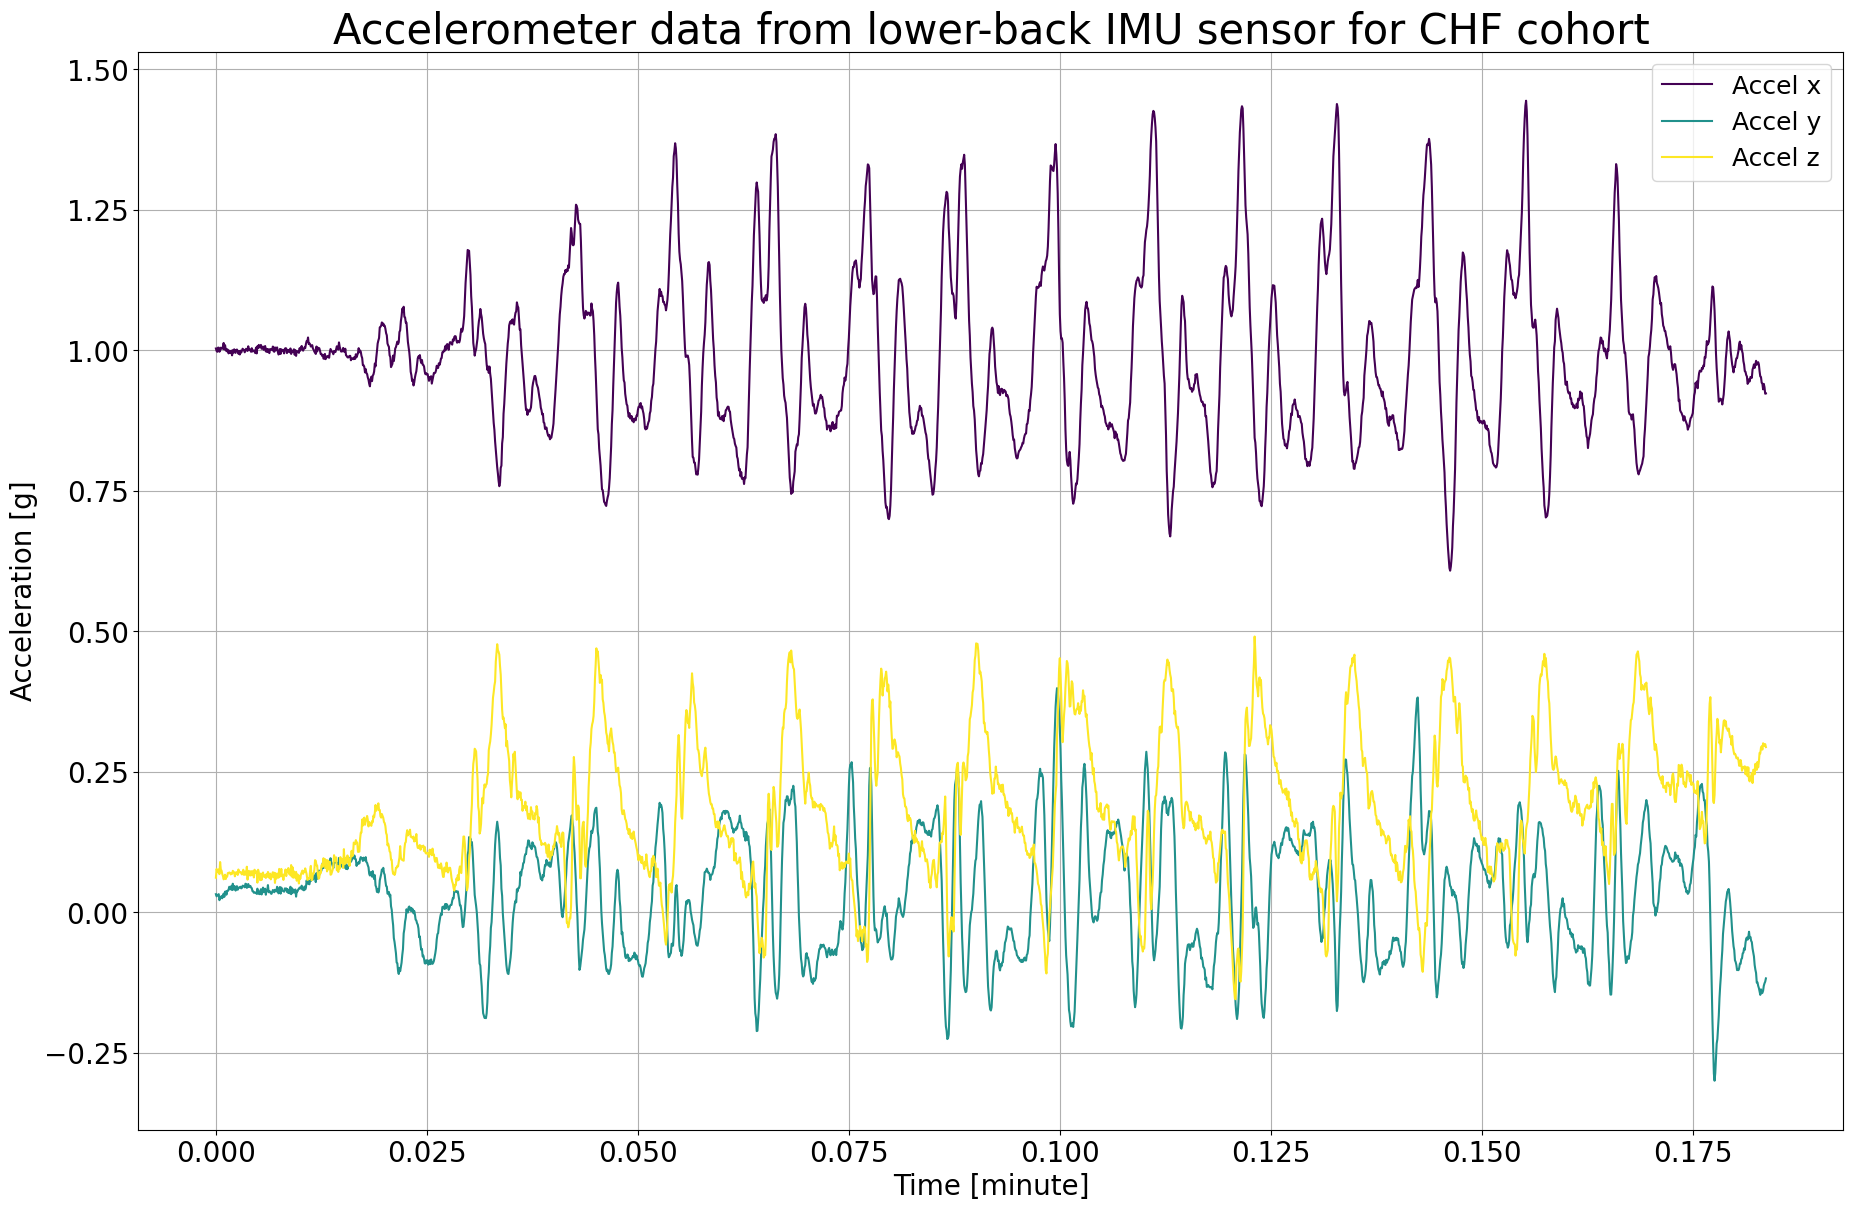

In [24]:
# Calculate the time values in minutes
# The 'time_in_minute' array represents time values in minutes, computed based on the length of 'acceleration_data' and 'sampling_frequency'.
time_in_minute = np.arange(len(acceleration_data)) / (60 * sampling_frequency)

# Create a figure with a specified size
plt.figure(figsize=(22, 14))

# Get colors for raw
colors = cfg_colors["raw"]

# A loop is used to plot data for each accelerometer axis, applying different colors from the color map.
for i in range(3):
    plt.plot(
        time_in_minute,
        acceleration_data.iloc[:,i],
        color = colors[i],
        label=f"Accel {'xyz'[i]}",

    )

# Add labels and legends
plt.xlabel("Time [minute]", fontsize=20)
plt.ylabel("Acceleration [g]", fontsize=20)
plt.legend(fontsize=18)

# Add a title with a specified font size
plt.title(
    "Accelerometer data from lower-back IMU sensor for CHF cohort",
    fontsize=30,
)

# Customize tick font sizes
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

# Display a grid for reference
plt.grid(visible=None, which="both", axis="both")

# Show the plot
plt.show()

## Applying Paraschiv-Ionescu Initial Contact Detection Algorithm
Now, we are running Paraschiv-Ionescu initial contact detection algorithm from icd module [`NGMT.ngmt.modules.icd._paraschiv.ParaschivIonescuInitialContactDetection`](https://github.com/neurogeriatricskiel/NGMT/tree/main/ngmt/modules/icd/_paraschiv.py) to detect initial contacts throughout the detected gait sequences. For this purpose, we have to first apply Paraschiv-Ionescu gait sequences detection algorithm to identify gait sequences using acceleration data. The gait sequences are detected by Paraschiv gait sequence detection ([`NGMT.ngmt.modules.gsd._paraschiv.ParaschivIonescuGaitSequenceDetection`](https://github.com/neurogeriatricskiel/NGMT/tree/main/ngmt/modules/gsd/_paraschiv.py)).

Then, in order to apply Paraschiv-Ionescu initial contact detection algorithm, an instance of the ParaschivIonescuInitialContactDetection class is created using the constructor, `ParaschivIonescuInitialContactDetection()`. The `icd` variable holds the instance, allowing us to access its methods. The inputs of Paraschiv-Ionescu initial contact detection algorithm are as follows:

- **Input Data:** `data` consist of accelerometer data (N, 3) for the x, y, and z axes in pandas Dataframe format.
- **Gait Sequences:** `gait_sequences`, consist of gait sequences detected by Paraschiv gait sequence detection ([`NGMT.ngmt.modules.gsd._paraschiv.ParaschivIonescuGaitSequenceDetection`](https://github.com/neurogeriatricskiel/NGMT/tree/main/ngmt/modules/gsd/_paraschiv.py)).
- **Sampling Frequency:** `sampling_freq_Hz` is the sampling frequency of the data, defined in Hz, with a default value of 100 Hz.



In [30]:
# Create an instance of the ParaschivIonescuGaitSequenceDetection class
gsd = ParaschivIonescuGaitSequenceDetection()

# Call the gait sequence detection using gsd.detect to detect gait sequences
gsd = gsd.detect(
    data=acceleration_data, sampling_freq_Hz=sampling_frequency, plot_results=False
)

# Gait sequences are stored in gait_sequences_ attribute of gsd
gait_sequences = gsd.gait_sequences_

# Now, use Paraschiv-Ionescu initial contact detection algortihm to find initial contacts within detected gait sequences.
icd = ParaschivIonescuInitialContactDetection()

# Call the initial contact detection using icd.detect
icd = icd.detect(
    data=acceleration_data,
    gait_sequences=gait_sequences,
    sampling_freq_Hz=sampling_frequency,
    v_acc_col_name="pelvis_accel_x"
)

# Print initial contacts information
print(icd.initial_contacts_)

1 gait sequence(s) detected.
    onset       event_type  duration tracking_systems
0   0.625  initial contact         0             None
1   1.200  initial contact         0             None
2   1.675  initial contact         0             None
3   2.450  initial contact         0             None
4   3.150  initial contact         0             None
5   3.850  initial contact         0             None
6   4.500  initial contact         0             None
7   5.175  initial contact         0             None
8   5.850  initial contact         0             None
9   6.550  initial contact         0             None
10  7.200  initial contact         0             None
11  7.850  initial contact         0             None
12  8.500  initial contact         0             None
13  9.175  initial contact         0             None
14  9.850  initial contact         0             None


## Visualization of the Detected Initial Contacts

In the following, the raw data of the lower back sensor is plotted with the detected events. The events are plotted as vertical lines. The events are:
- **Gait onset**: Start of the gait sequence
- **Gait duration**: Duration of the gait sequence
- **Initial contacts**: Initial contacts

The gait onset is represented with the vertical green line and the grey area represents the duration of gait sequence detected by the algorithm. The vertical dashed blue lines are representing detected initial contacts within first gait sequence.

First Gait Sequence: onset                        0.0
duration                    11.0
event_type         gait sequence
tracking_system             None
Name: 0, dtype: object

Initial Contacts within the First Gait Sequence:     onset       event_type  duration tracking_systems
0   0.625  initial contact         0             None
1   1.200  initial contact         0             None
2   1.675  initial contact         0             None
3   2.450  initial contact         0             None
4   3.150  initial contact         0             None
5   3.850  initial contact         0             None
6   4.500  initial contact         0             None
7   5.175  initial contact         0             None
8   5.850  initial contact         0             None
9   6.550  initial contact         0             None
10  7.200  initial contact         0             None
11  7.850  initial contact         0             None
12  8.500  initial contact         0             None
13  9.175  initial

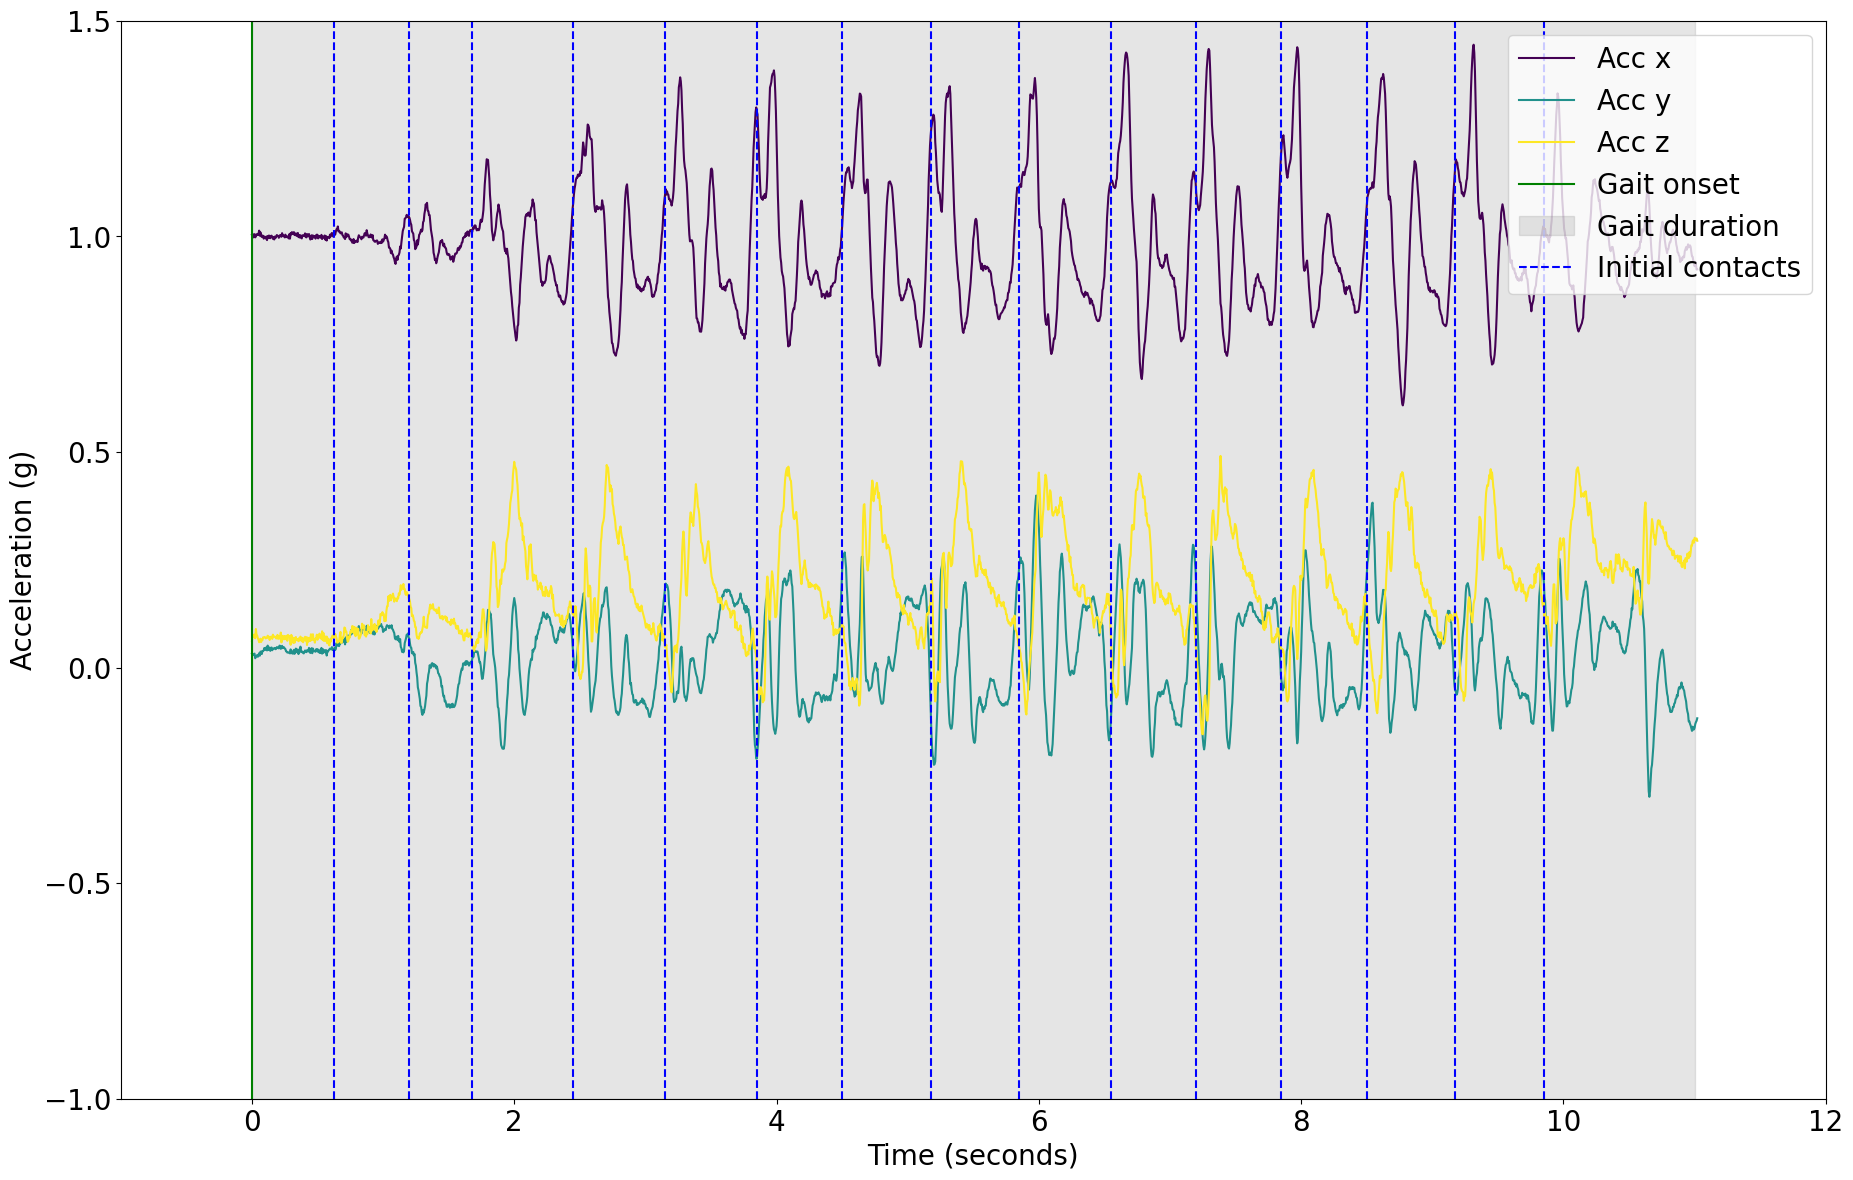

In [31]:
# Access the first detected gait sequence
first_gait_sequence = gsd.gait_sequences_[gsd.gait_sequences_["event_type"] == "gait sequence"].iloc[0]

# Print information about the first gait sequence
print("First Gait Sequence:", first_gait_sequence)

# Print information about initial contacts within the first gait sequence
ic_within_gait = icd.initial_contacts_[
    icd.initial_contacts_["onset"].between(
        first_gait_sequence["onset"],
        first_gait_sequence["onset"] + first_gait_sequence["duration"],
    )
]
print("\nInitial Contacts within the First Gait Sequence:", ic_within_gait)

# Plot the raw data from the lower back
fig, ax = plt.subplots(figsize=(22, 14))

# Plot raw acceleration data
for i in range(3):
    ax.plot(
        time_seconds,
        acceleration_data.iloc[:, i],
        color=colors[i],
        label=f"Acc {'xyz'[i]}",
    )

# Plot the first element of gait sequences
plt.axvline(first_gait_sequence["onset"], color="g", label="Gait onset")
ax.axvspan(
    first_gait_sequence["onset"],
    first_gait_sequence["onset"] + first_gait_sequence["duration"],
    alpha=0.2,
    color="gray",
    label="Gait duration",
)

# Plot the initial contacts within the first gait sequence
for ic_time in ic_within_gait["onset"]:
    ax.axvline(ic_time, color="blue", linestyle="--")

# Customize plot
start_limit = first_gait_sequence["onset"] - 1
end_limit = first_gait_sequence["onset"] + first_gait_sequence["duration"] + 1
ax.set_xlim(start_limit, end_limit)
ax.set_ylim(-1, 1.5)
ax.set_xlabel("Time (seconds)", fontsize=20)
ax.set_ylabel("Acceleration (g)", fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
ax.legend(
    ["Acc x", "Acc y", "Acc z", "Gait onset", "Gait duration", "Initial contacts"],
    fontsize=20,
    loc="upper right",
)
plt.show()